In [1]:
import pandas as pd
import seaborn as sns; sns.set_style("darkgrid")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import janitor
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_categorical_dtype

In [2]:
df = pd.read_csv("../data/Employee.csv").clean_names()
#df

In [3]:
train, test = train_test_split(df, train_size=0.8, random_state=42, stratify=df["leaveornot"])

In [4]:
train.to_csv("../data/train.csv", index=False)
test.to_csv("../data/test.csv", index=False)

In [5]:
train.head()

,education,joiningyear,city,paymenttier,age,gender,everbenched,experienceincurrentdomain,leaveornot
4097,Bachelors,2012,New Delhi,3,38,Female,No,1,0
1694,Bachelors,2018,Bangalore,3,26,Male,No,4,1
2659,Bachelors,2016,Pune,3,27,Male,No,5,0
3860,Bachelors,2016,Bangalore,3,36,Male,No,4,0
1250,Bachelors,2017,Bangalore,3,27,Male,Yes,5,0


In [6]:
train.shape

(3722, 9)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3722 entries, 4097 to 4150
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   education                  3722 non-null   object
 1   joiningyear                3722 non-null   int64 
 2   city                       3722 non-null   object
 3   paymenttier                3722 non-null   int64 
 4   age                        3722 non-null   int64 
 5   gender                     3722 non-null   object
 6   everbenched                3722 non-null   object
 7   experienceincurrentdomain  3722 non-null   int64 
 8   leaveornot                 3722 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 290.8+ KB


In [8]:
train["education"].unique()

array(['Bachelors', 'Masters', 'PHD'], dtype=object)

In [9]:
train["city"].unique()

array(['New Delhi', 'Bangalore', 'Pune'], dtype=object)

In [10]:
train["paymenttier"].unique()

array([3, 2, 1])

In [11]:
train["experienceincurrentdomain"].unique()

array([1, 4, 5, 2, 0, 3, 6, 7])

In [12]:
train["joiningyear"].unique()

array([2012, 2018, 2016, 2017, 2013, 2015, 2014])

In [13]:
### converting specific columns
train["joiningyear"] = train["joiningyear"].astype("category")
train["paymenttier"] = train["paymenttier"].astype("category")
train["experienceincurrentdomain"] = train["experienceincurrentdomain"].astype("category")
train["city"] = train["city"].astype("category")
train["education"] = train["education"].astype("category")
train["everbenched"] = train["everbenched"].astype("category")

### Univariate analysis

In [14]:
def cat_eda(var):
    plt.figure(figsize=(15,10))
    sns.countplot(x = var, data = train, hue  = "leaveornot")
    plt.show();

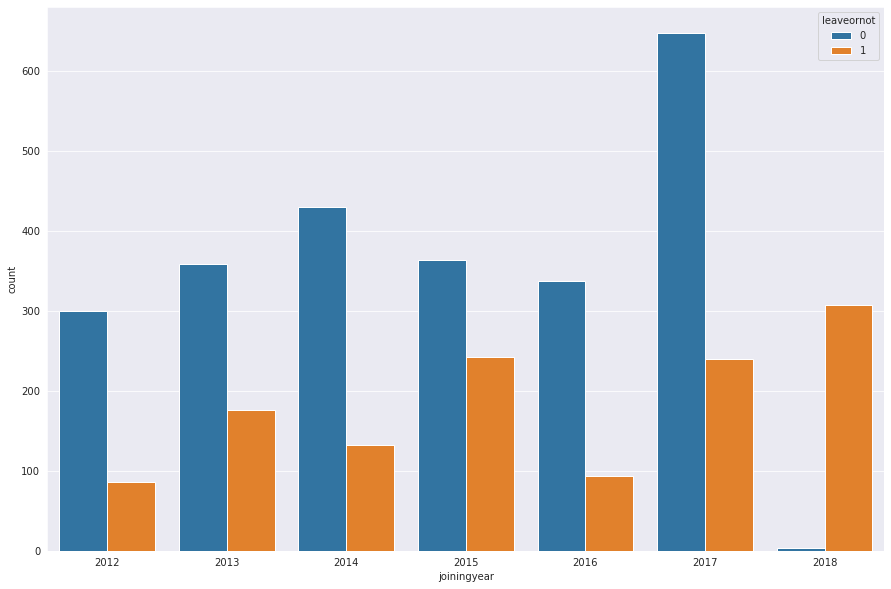

In [15]:
cat_eda("joiningyear")

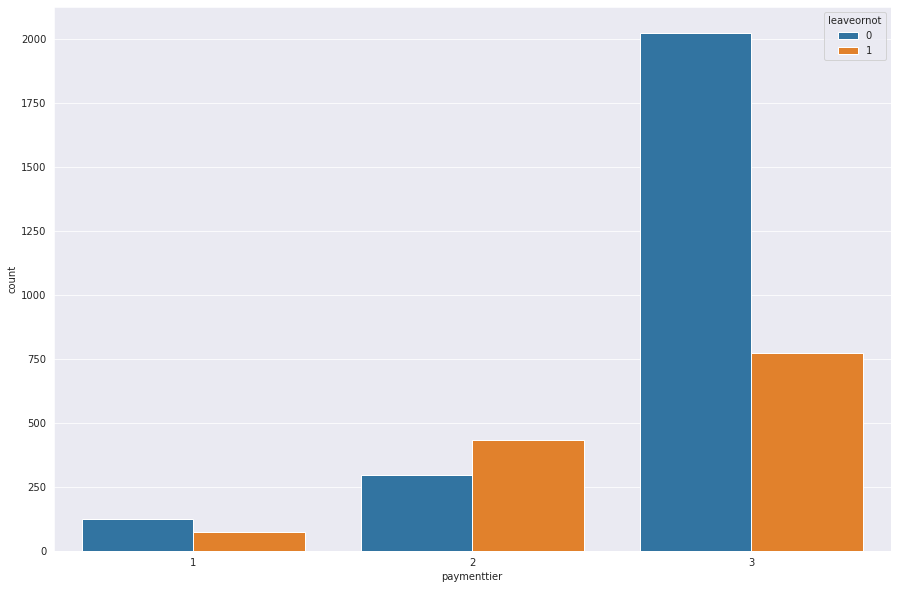

In [16]:
cat_eda("paymenttier")

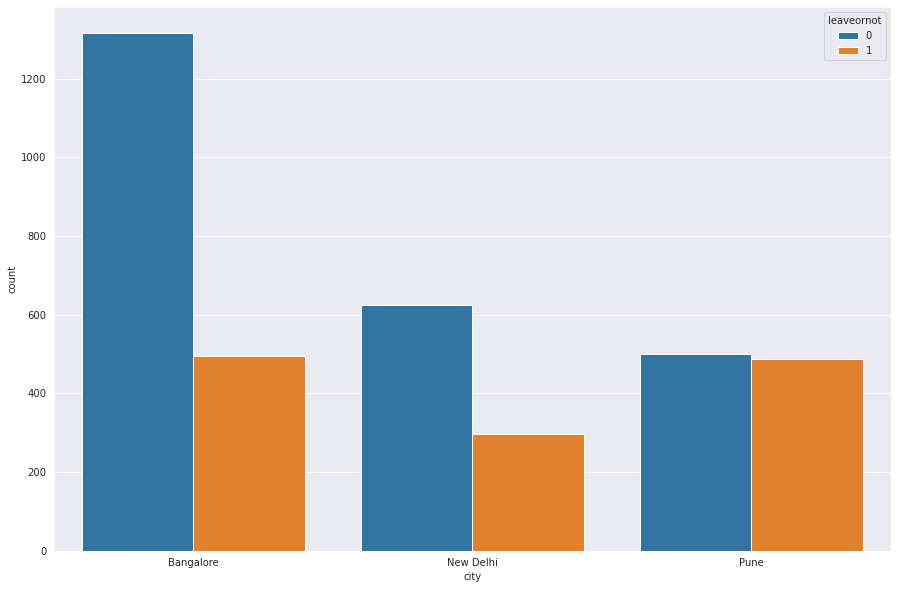

In [17]:
cat_eda("city")

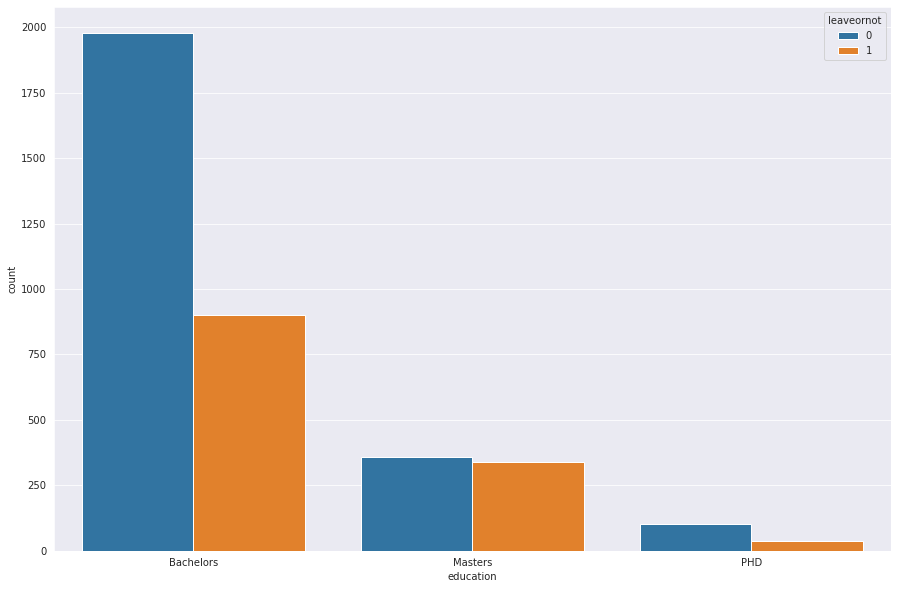

In [18]:
cat_eda("education")

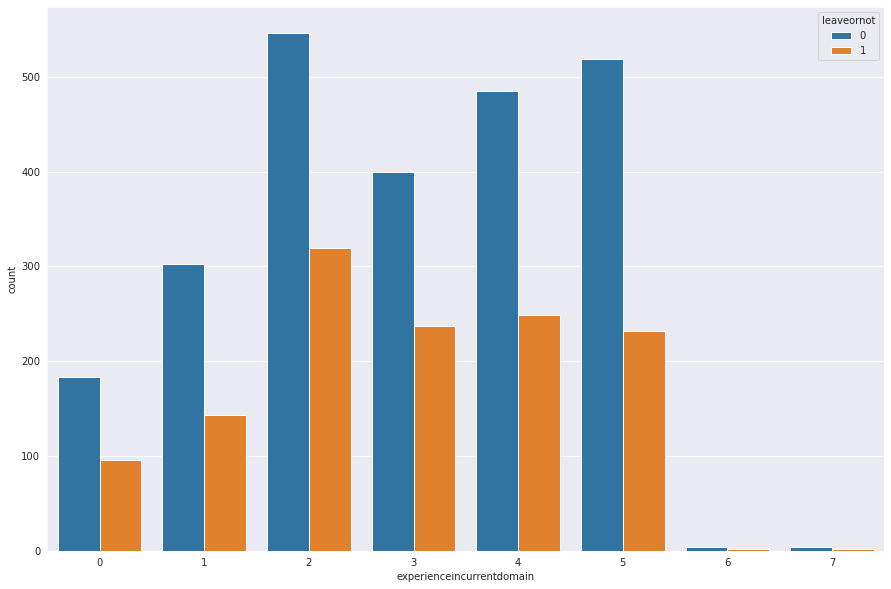

In [19]:
cat_eda("experienceincurrentdomain")

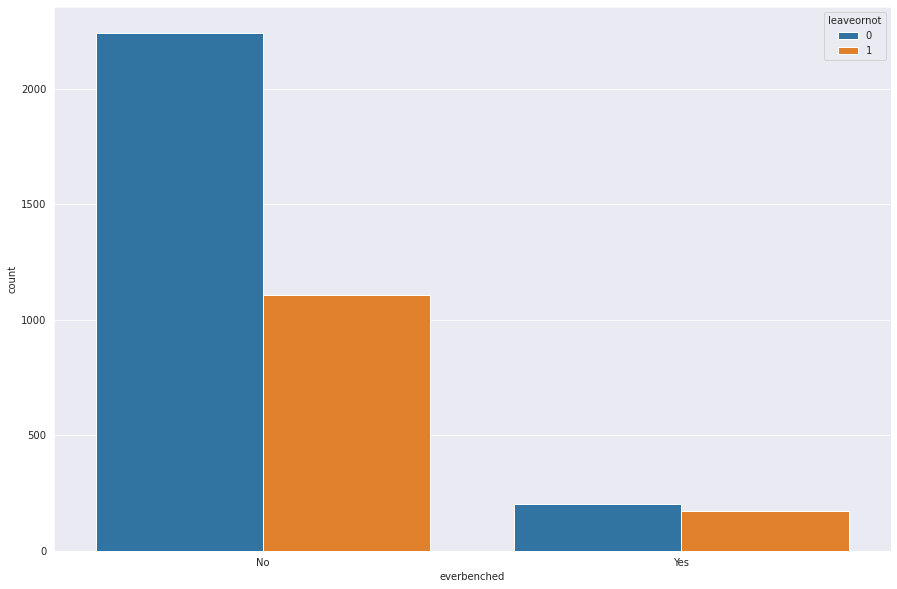

In [20]:
cat_eda("everbenched")

In [21]:
def num_eda(var):
    plt.figure(figsize=(15,10))
    sns.kdeplot(x = var, data = train, hue  = "leaveornot")
    plt.show(); 

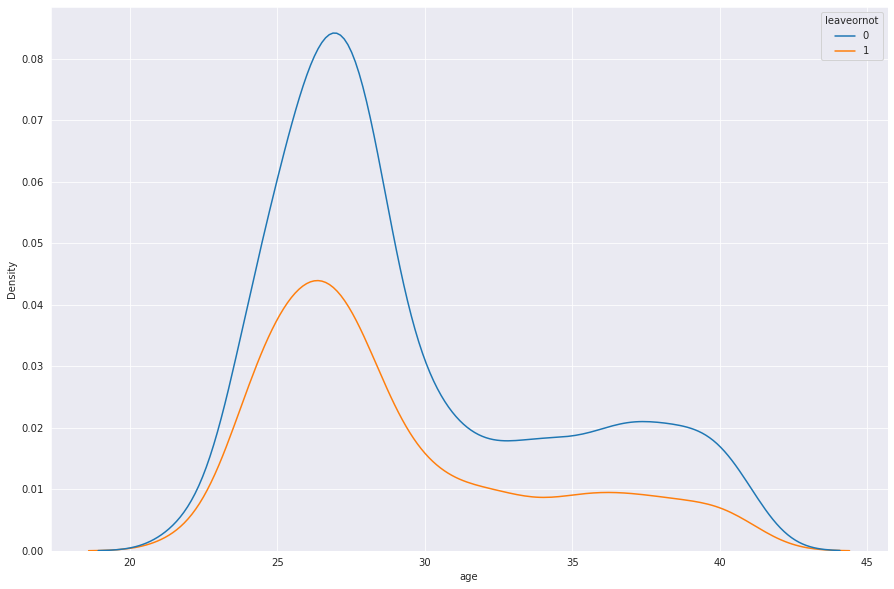

In [22]:
num_eda("age")

### Multivariate Analysis

In [23]:
cat_col = []
num_col = []
for col in list(train.columns):
    if is_categorical_dtype(train[col]):
        cat_col.append(col)
    elif is_numeric_dtype(train[col]):
        num_col.append(col)

In [24]:
num_col, cat_col

(['age', 'leaveornot'],
 ['education',
  'joiningyear',
  'city',
  'paymenttier',
  'everbenched',
  'experienceincurrentdomain'])

In [25]:
num_col.remove("leaveornot")

In [26]:
len(num_col)

1

In [27]:
def multiple_cat_num_eda(num, cat):
    fig, axes = plt.subplots(ncols=1, nrows=len(cat), figsize = (30, 60))
    for j in range(len(cat)):
      #if var_list[i] != var_list[j]:
        sns.violinplot(x = cat[j], y = num[0], data = train, hue = "leaveornot", ax = axes[j])
        ax = axes[j]
        ax.set_ylabel(num[0], fontsize=14)
        ax.set_xlabel(cat[j], fontsize=14)

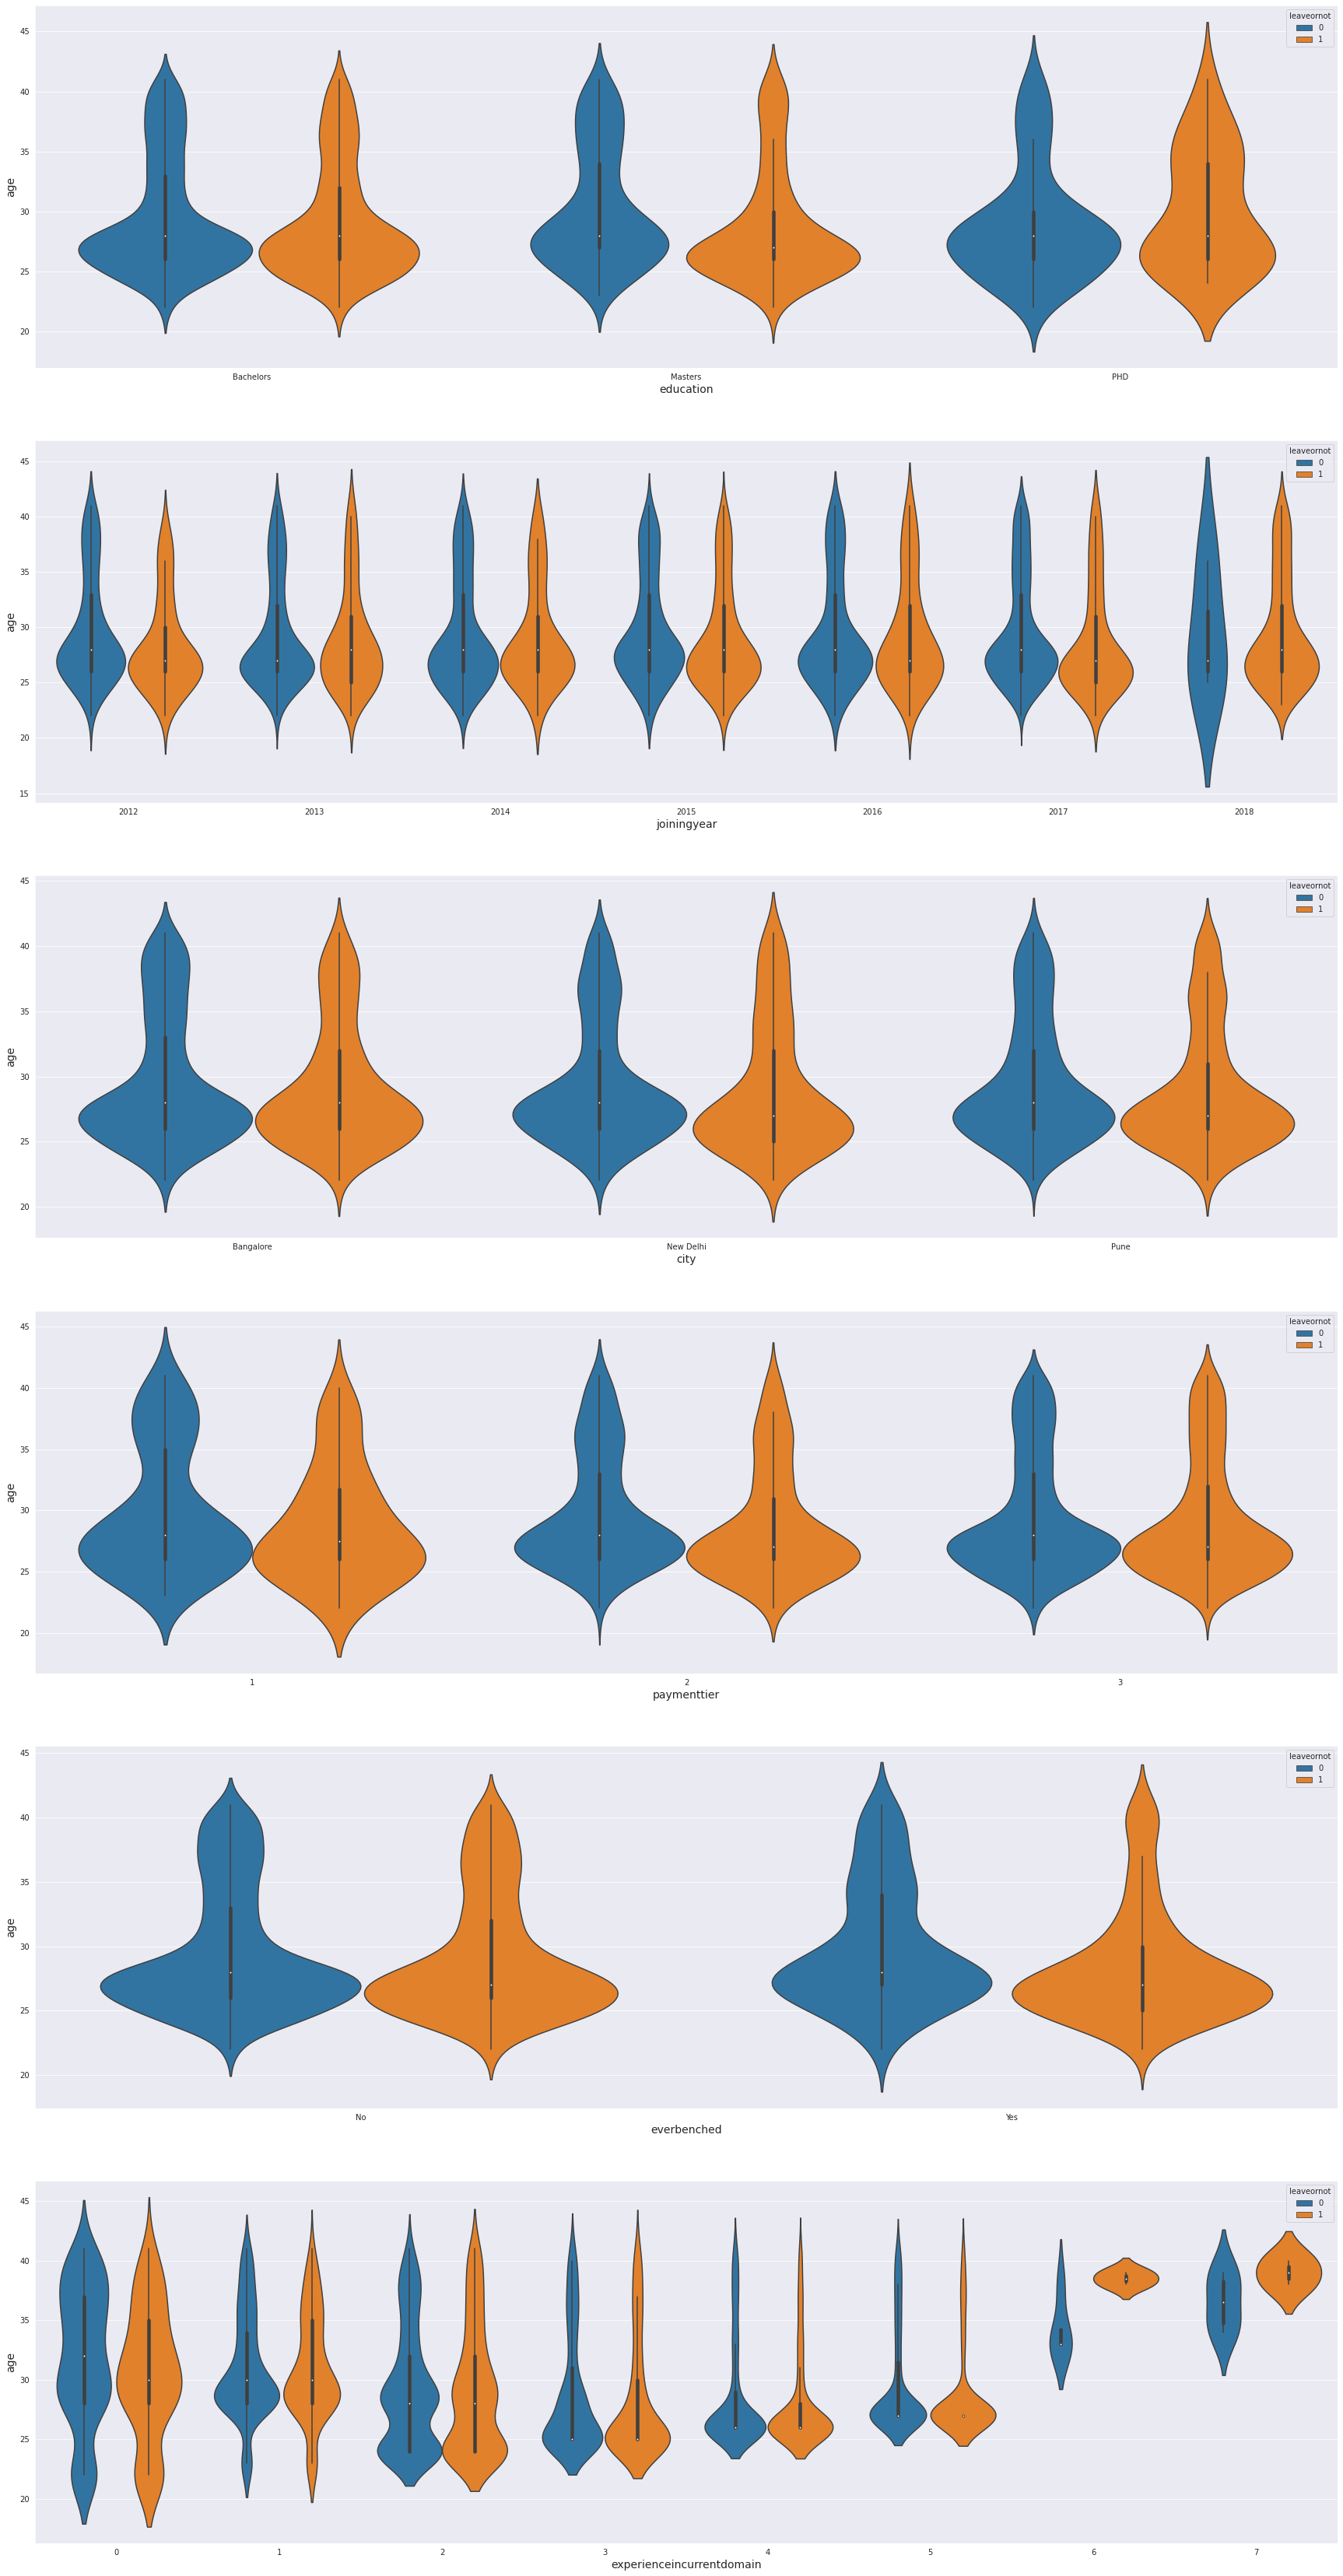

In [28]:
multiple_cat_num_eda(num_col, cat_col)

In [29]:
def cat_cat_churn(var1, var2):
    train_use = train[[var1, var2, "leaveornot"]]
    train_use = train_use.groupby([var1, var2, "leaveornot"], as_index = False).size()
    train_use = train_use.pivot_table(index = [var1, var2], columns = "leaveornot", values = "size")
    train_use = train_use.rename(columns = {0: "No", 1: "Yes"})
    train_use["prop_leave"] = train_use["Yes"] / (train_use["No"] + train_use["Yes"])
    train_use = train_use.fillna(0)
    train_use["group"] = train_use.index
    train_use = train_use.reset_index(drop = True)
    train_use = train_use.rename_axis(None, axis=1)
      #train_use["group"]
    train_use[var1] = train_use["group"].str.get(0)
    train_use[var2] = train_use["group"].str.get(1)
    train_use = train_use.drop(["group"], axis = 1)
    train_use = train_use.rename_axis(None, axis=0)
    pivot_df = train_use.pivot(var1, var2, "prop_leave")
    return pivot_df
     

In [30]:
def multiple_cat_cat_eda(var_list):
    fig, axes = plt.subplots(nrows=len(var_list), ncols=len(var_list), figsize = (40, 60))
    for i in range(len(var_list)):
        for j in range(len(var_list)):
            if var_list[i] != var_list[j]:
                new_df = cat_cat_churn(var_list[i], var_list[j])
                sns.heatmap(new_df, annot=True, fmt=".2f", linewidths=.5, cmap="RdBu", ax=axes[i,j])
                ax = axes[i,j]
                ax.set_ylabel(var_list[i], fontsize=8)
                ax.set_xlabel(var_list[j], fontsize=8)
            else:
                sns.countplot(x = var_list[i], data = train, ax=axes[i,i])
                ax = axes[i,i]
                ax.set_xlabel(var_list[i], fontsize=8)
                ax.set_ylabel(var_list[i], fontsize=8)

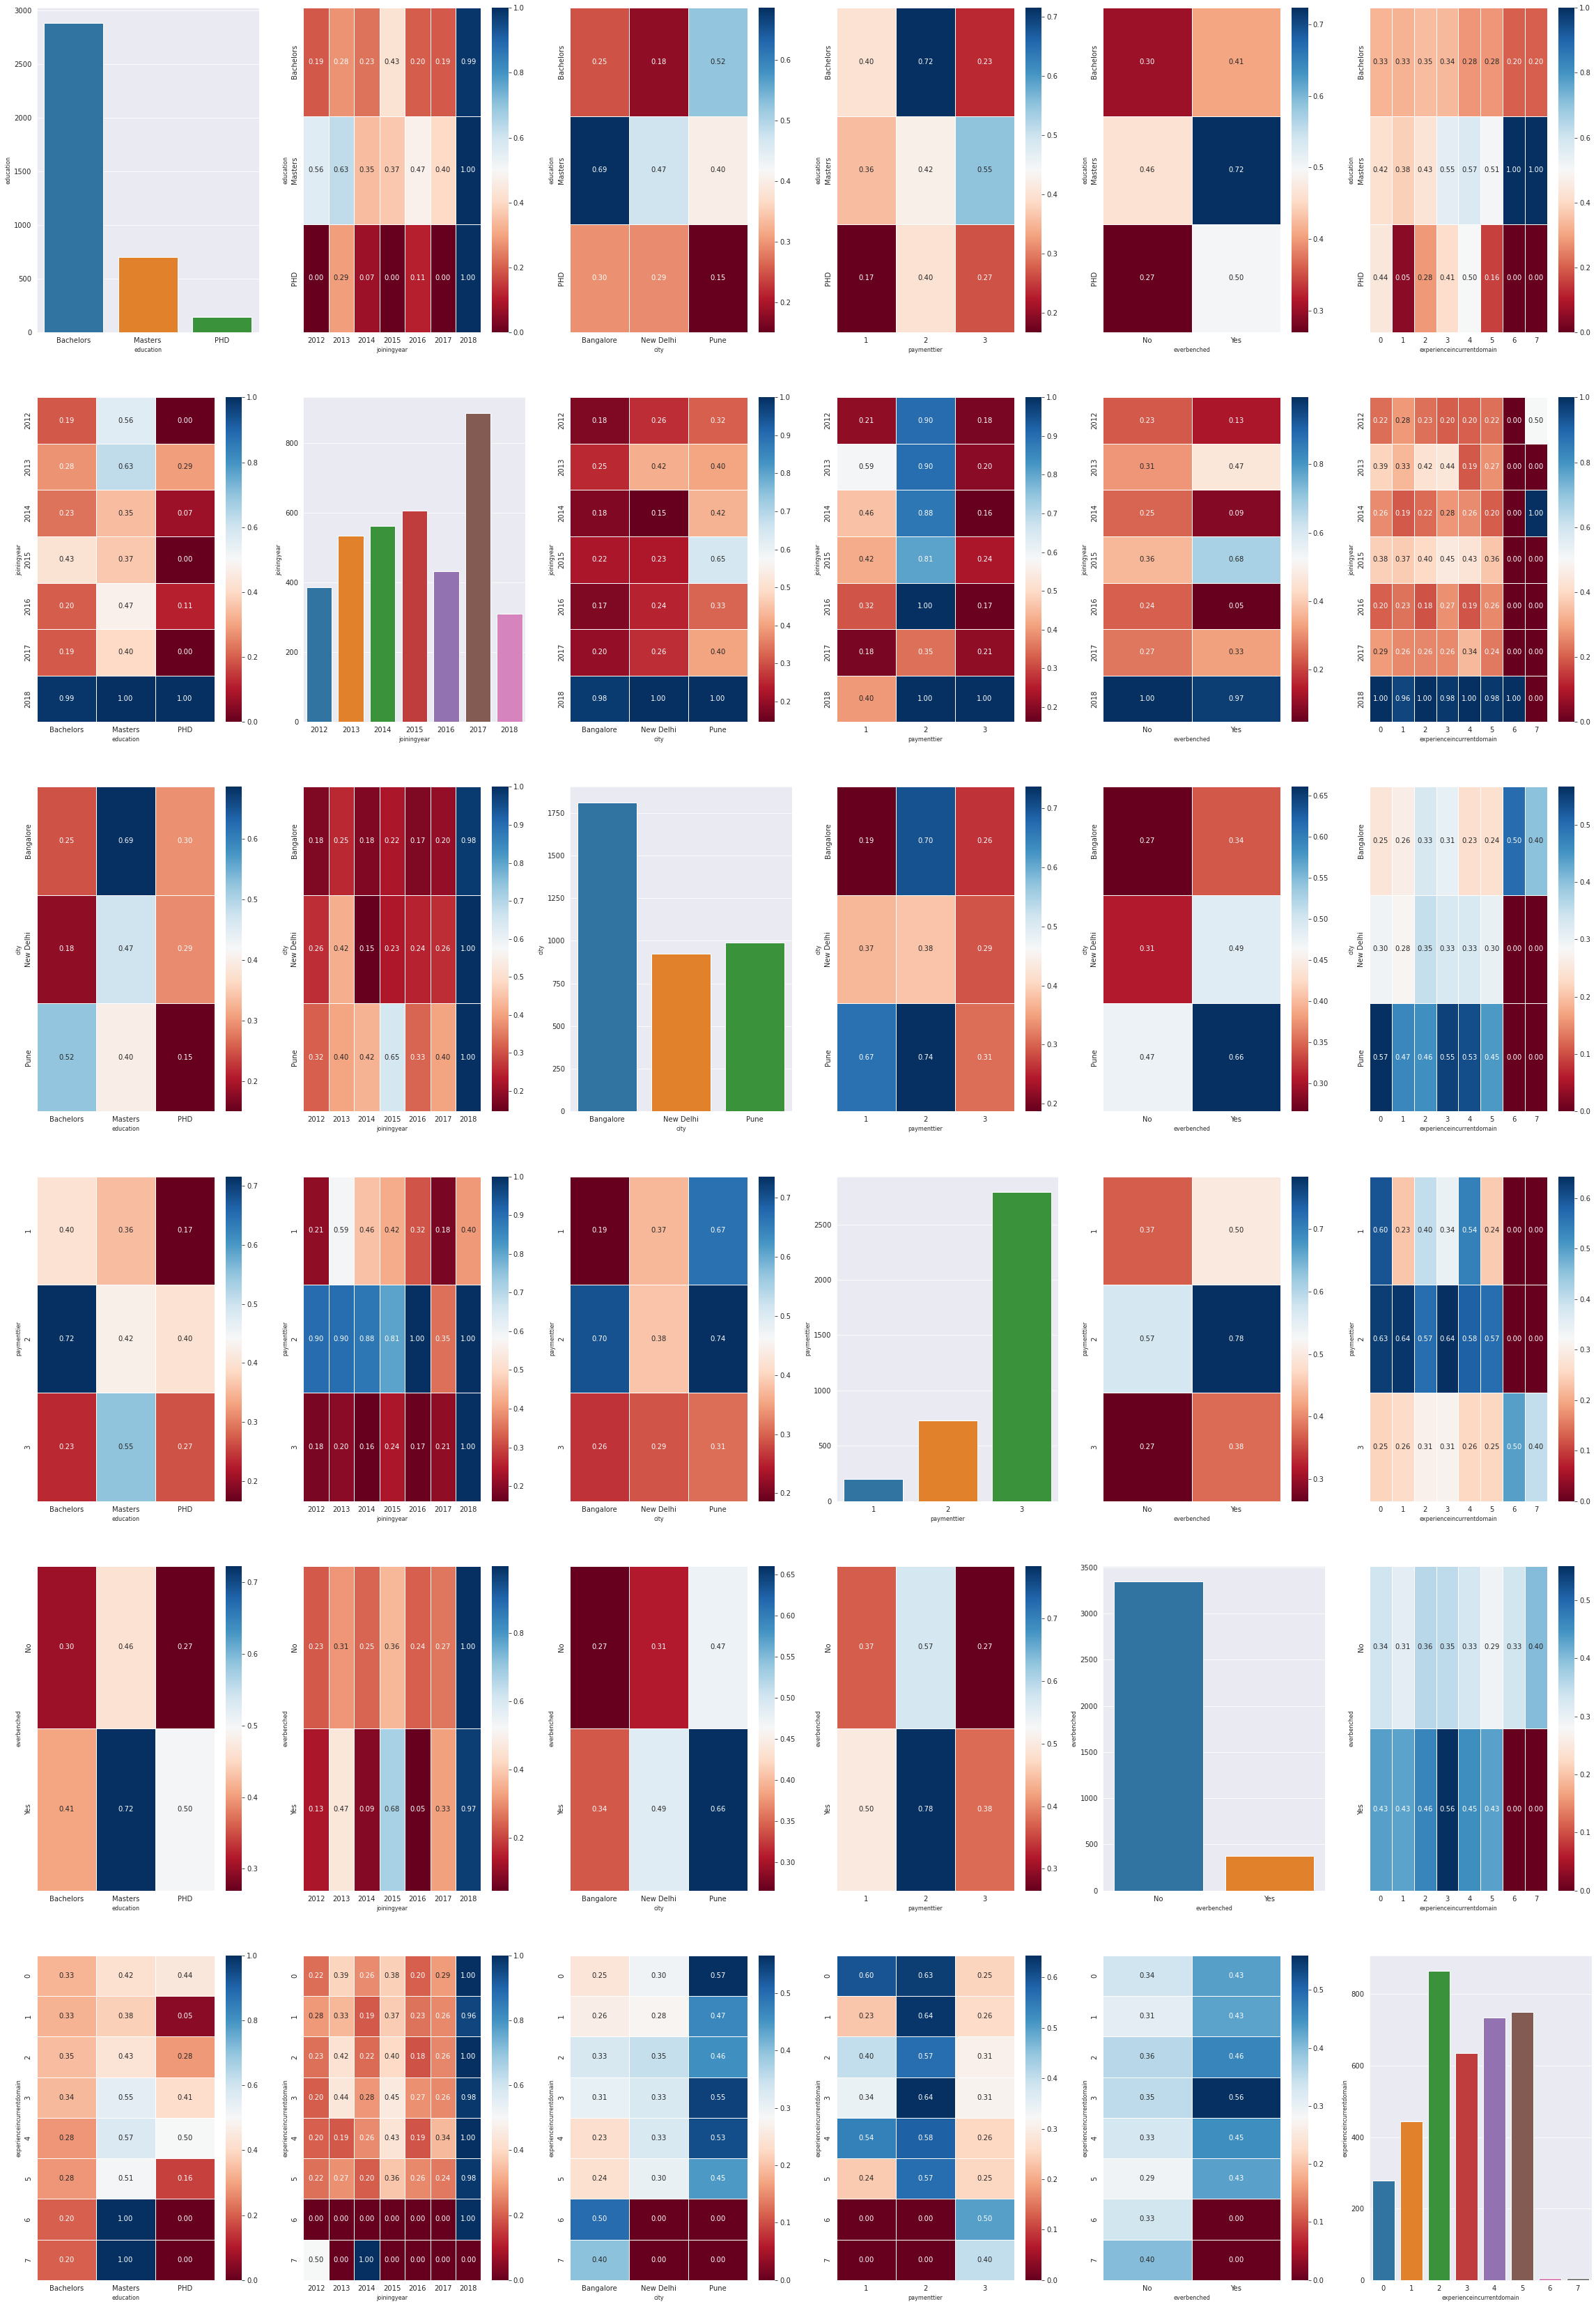

In [31]:
multiple_cat_cat_eda(cat_col)